In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os, sys
ROOT_DIR = os.path.abspath(r"c:\Users\srb\PycharmProjects\Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils

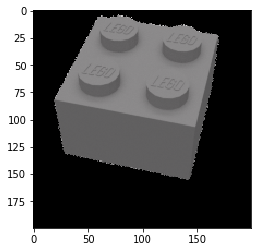

In [240]:
img = cv2.imread('c://Users//srb//PycharmProjects//Mask_RCNN//images//3003 Brick 2x2//0001.png')
plt.imshow(img)

<b>TODO</b> сейчас будем делать просто приведением всех рисунков к серому, потом можночто то придумать с изменением количества каналов

In [21]:
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
bg_color

array([212,  46, 101])

In [38]:
def random_shape(height, width):
    """Generates specifications of a random shape that lies within
    the given height and width boundaries.
    Returns a tuple of three valus:
    * The shape name (square, circle, ...)
    * Shape color: a tuple of 3 values, RGB.
    * Shape dimensions: A tuple of values that define the shape size
                        and location. Differs per shape type.
    """
    # Shape
    shape = random.choice(["brick", "plate"])
    # Color
    color = tuple([random.randint(0, 255) for _ in range(3)])
    # Center x, y
    buffer = 20
    y = random.randint(buffer, height - buffer - 1)
    x = random.randint(buffer, width - buffer - 1)
    # Size
    s = random.randint(buffer, height//4)
    return shape, color, (x, y, s)

In [26]:
def random_image(height, width):
    """Creates random specifications of an image with multiple shapes.
    Returns the background color of the image and a list of shape
    specifications that can be used to draw the image.
    """
    # Pick random background color
    bg_color = np.array([random.randint(0, 255) for _ in range(3)])
    # Generate a few random shapes and record their
    # bounding boxes
    shapes = []
    boxes = []
    N = random.randint(1, 4)
    for _ in range(N):
        shape, color, dims = random_shape(height, width)
        shapes.append((shape, color, dims))
        x, y, s = dims
        boxes.append([y-s, x-s, y+s, x+s])
    # Apply non-max suppression wit 0.3 threshold to avoid
    # shapes covering each other
    keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
    shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
    return bg_color, shapes

In [39]:
random_image(128,128)

(array([129,  91, 154]),
 [('brick', (65, 251, 175), (64, 23, 31)),
  ('plate', (231, 50, 237), (69, 69, 23))])

In [46]:
def load_image(sf,image_id):
    """Generate an image from the specs of the given image ID.
    Typically this function loads the image from a file, but
    in this case it generates the image on the fly from the
    specs in image_info.
    """
    info = sf.image_info[image_id]
    bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
    image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
    image = image * bg_color.astype(np.uint8)
    for shape, color, dims in info['shapes']:
        image = sf.draw_shape(image, shape, dims, color)
    return image

In [110]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_CUBIC)

    # return the resized image
    return resized

In [43]:
height = 128
width = 128
sf = utils.Dataset()
for i in range(20):#count
    bg_color, shapes = random_image(height, width)
    sf.add_image("shapes", image_id=i, path=None,
                   width=width, height=height,
                   bg_color=bg_color, shapes=shapes)

In [49]:
load_image(sf, 0)

AttributeError: 'Dataset' object has no attribute 'draw_shape'

<b>надо написать функцию вставки</b>

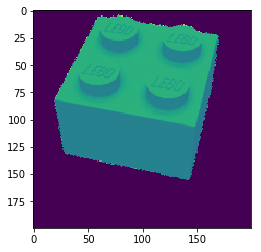

In [156]:
img_raw =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_raw = image_resize(img_raw, height=128)
plt.imshow(img_raw)
#

In [137]:
img_raw.shape

(200, 200)

In [166]:
contours, hierarchy = cv2.findContours(img_raw,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

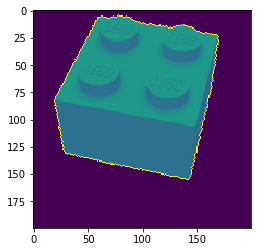

In [167]:
# img_for_show = img.copy()
img_for_show = img_raw.copy()
# img_for_show = image_resize(img_for_show, height=128)
cv2.drawContours(img_for_show, contours, 0, (255), 1, hierarchy = hierarchy)
plt.imshow(img_for_show)

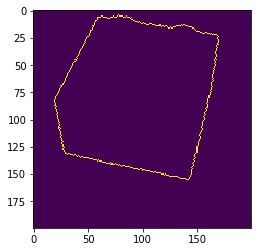

In [168]:
# iIndTrue = contours[0].reshape((2,-1))
# mask_ = np.zeros(img_raw.shape,dtype = np.bool)
mask_ = np.zeros(img_raw.shape)
# mask_[iIndTrue[0],iIndTrue[1]] = True
cv2.drawContours(mask_, contours, -1, (255), 1, hierarchy = hierarchy)

plt.imshow(mask_)

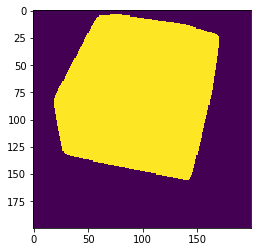

In [195]:
def createMask(size, contours, return_is_bool=False):
    hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
    hull = np.vstack(hull_contours)
    # black image
    rows, cols = size
#     mask = np.zeros((rows, cols,1), dtype=np.uint8)
    mask = np.zeros((rows, cols), dtype=np.uint8)
    # blit our contours onto it in white color
    cv2.drawContours(mask, [hull], 0, 1, -1)
#     mask = mask.reshape((rows, cols,1))
    if return_is_bool:
        mask = mask.astype(np.bool)
    return mask


mask = createMask(img_raw.shape[0:2], contours)
plt.imshow(mask)

In [334]:
def change_color(img,clr):
    img_norm = img.copy()
    img_norm = img_norm / 255.
    clr = np.array(clr)
    clr = clr / 255.
    img_norm *= clr
    img_norm = (img_norm*255.).astype(np.uint8)
#     plt.imshow(img_norm)
    return img_norm

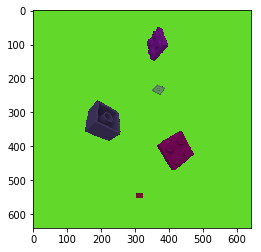

In [397]:
def prepare_data(img_info):
    bg_color = np.array(img_info['bg_color']).reshape([1, 1, 3])
    img1 =  np.ones([img_info['height'], img_info['width'], 3], dtype=np.uint8)
    img1 =  img1  * bg_color.astype(np.uint8)
    mask_full = np.zeros((img_info['height'], img_info['width']),dtype=np.uint8)
    masks = []
    for detail_type, color, (x,y,s), path in img_info['details']:
        img2 = cv2.imread(path)
        
        img2 = image_resize(img2,  height=s)
        img2 = change_color(img2,color)
        # I want to put logo on top-left corner, So I create a ROI
        rows,cols,channels = img2.shape
        mask = np.zeros((rows,cols),dtype=np.uint8)
        roi = img1[y:rows+y, x:cols+x]
#         print(x)
#         print(roi.shape)
#         print(img2.shape)
        # Now create a mask of logo and create its inverse mask also
        img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
#         print(mask_inv.shape)
        # Now black-out the area of logo in ROI
        img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
        # Take only region of logo from logo image.
        img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
        # Put logo in ROI and modify the main image
        dst = cv2.add(img1_bg,img2_fg)
        img1[y:rows+y, x:cols+x] = dst
        tmp_mask_full = mask_full.copy()
        tmp_mask_full[y:rows+y, x:cols+x] = mask
        tmp_mask_full = tmp_mask_full.reshape((img_info['height'], img_info['width'], 1))
        
        masks.append(tmp_mask_full)
    masks = np.concatenate(masks,axis=2)
    return img1, masks
result_img, result_masks = prepare_data(img_info2)
plt.imshow(result_img)

In [381]:
np.concatenate(result_masks,axis=2).shape

(640, 640, 3)

In [398]:
dic1 = {}
dic2 = {}

for inf in list_info:
    result_img, result_masks = prepare_data(inf)
    dic1.update({inf['id']:result_img}) 
    dic2.update({inf['id']:result_masks}) 

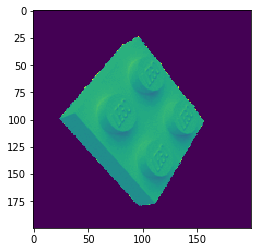

In [335]:
img2 = cv2.imread(r'c:\Users\srb\PycharmProjects\Mask_RCNN\images\3022 Plate 2x2\201706161906-0105.png')
img2 = change_color(img2,color)
img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
plt.imshow(img2gray)


In [395]:

img_info = {'id': 2,
 'source': 'details',
 'path': None,
 'width': 640,
 'height': 640,
 'bg_color': np.array([202, 106,  49]),
 'details': [('brick',
   (183, 16, 51),
   (436, 202, 97),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0227.png'),
  ('brick',
   (193, 87, 93),
   (107, 53, 81),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0130.png'),
  ('plate',
   (135, 55, 7),
   (138, 459, 157),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0127.png'),
  ('brick',
   (178, 176, 244),
   (263, 403, 84),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0216.png'),
  ('brick',
   (123, 181, 129),
   (467, 274, 44),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0084.png'),
  ('plate',
   (56, 50, 19),
   (570, 220, 30),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0059.png'),
  ('brick',
   (115, 66, 13),
   (525, 260, 63),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0154.png'),
  ('brick',
   (81, 196, 200),
   (49, 533, 23),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0341.png'),
  ('brick',
   (207, 172, 197),
   (173, 291, 134),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0238.png'),
  ('brick',
   (188, 5, 79),
   (339, 248, 82),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0143.png'),
  ('plate',
   (48, 232, 32),
   (91, 97, 155),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0093.png'),
  ('plate',
   (138, 107, 118),
   (293, 310, 67),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0058.png')]}
img_info2 = {'id': 1,
 'source': 'details',
 'path': None,
 'width': 640,
 'height': 640,
 'bg_color': np.array([ 97, 216,  42]),
 'details': [('plate',
   (145, 217, 147),
   (343, 208, 51),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0399.png'),
  ('plate',
   (164, 29, 197),
   (296, 35, 128),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0137.png'),
  ('brick',
   (122, 102, 181),
   (144, 236, 155),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0316.png'),
  ('brick',
   (236, 44, 98),
   (296, 534, 32),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3003 Brick 2x2\\0092.png'),
  ('plate',
   (180, 13, 135),
   (346, 334, 154),
   'c:\\Users\\srb\\PycharmProjects\\Mask_RCNN\\images\\3022 Plate 2x2\\201706161906-0104.png')]}
list_info = [img_info,img_info2]

In [236]:

# info = self.image_info[image_id]
info = img_info
bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)
# for detail, color, dims in info['details']:
#     print(image, detail, dims, color)
#     image = draw_detail(image, detail, dims, color) #self

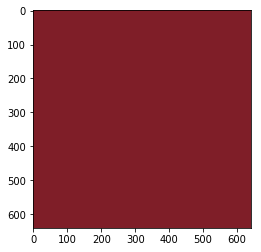

In [217]:
result_img = cv2.add(image[0:200,0:200], img, mask=mask, dst=(0,0))
plt.imshow(image)